## TODO

* read my presentaion about transformer
* instead of learning the dissimilarity, calculate cosine similarity 


- Train on  **transcription** istead of the **description**
: Problems: bert is given an input of only size 512, and the transcroption length may be in length of 1500/
Solution: Dim rediction, LongTransformer, Tf-idf

- Unique words in each category

- Overlap words in different categories


- take the embedding of the bert (without an additional FF layer) + calculate cosine similarity between the embedded vectors.



# TODO2

**build a network that learns embedding vectors prodiuces by a trained BERT.
he idea: "copy" network by a less size network.**

---

types of lossess 

---




https://towardsdatascience.com/how-to-choose-your-loss-when-designing-a-siamese-neural-net-contrastive-triplet-or-quadruplet-ecba11944ec

TODO:

change input to the constrativeLOss: it gets as input the feature vectors, and not the distance between them! it by itself calculating the distance between them. if the loss was BCE - only then we should pass the distance.

# Difficulties

- long run-time of getting the prototypes: I hanlded it by doing batchs of size bigger than 1 
- CUDA memory issue when getting prototype: i decreased the batch size of the trainLoader_simple from 512 to 32


# TODO3
**Problem:**
The training loss is not decreasing (the network stop learning). Possibole reasons:
- we reached into a local minmum (decrease/increase learning rate)
- the model is too simple for the data. 
- our data just doesn’t contain meaningful information that lets it explain the output

**Conclusion so far:**
- with only 2 categories the loss decresed from 0.6 to 0.2.
- so maybe if we will do more complex network it will help for 5 categories.


**What to change:**

- Hyperparametrs
  - learning rate: use sceduler = scyclic learning rate
  - btach size
  - loss function
  - optimizer


- Data
  - Deal with imbalance datast (SMOTE / change sample procedure in the datalaoder)
  - reduce number of categories to 2 - it went from 0.6 to 0.3 but them stop there
  - instead of using the description (less accurate than the transcription)  or using the full transcription (too heavy), sample from the transcription a text of 512 characters  (kind of augmentation).
  - train on other dataset (simpler dataset)
  - spam dataset (2 caegories) - 20 epochs stuck around 0.2
  - make the dataloader sample equally from all classes ?
  - change to "transcription" of size 512 - didn't work (stucked on 0.6)


- Architecture
  - **increase the complexity of the model - more FF layers / 1d convolution**
  -  **change distance layer (to cosine distance maybe)**
  - **leave only 1 fine tuning layer, and instead add more FF layer to the distance layer**
  - discard finetuning FF layer - didn't work
  - decrease the dimension of finetuning layer from 128 to 64 - didn't work
  - increase the dimension of finetunning layer from 128 to 512 - didn't work
  - change to rnn instead of bert - 
  - change to idftf instead of bert
  - Check the bert embedding on the train set (plot it on 3d and see if the categories are seperated)
  - check if the vocabelry of BERT is similar to our data vocabelry (see maybe if the ids of the texts contain many UNKNOWN symbol)
  - Add another layer of finetuning FF (if the SNN doesnt learn we should try yo increase its power. More parametrs = more power)

- General
  - train with keras
  - train with this code: https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/
  -(maybe I have a problem with no_grads or smething)

# **Imports**

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns
import plotly.graph_objects as go

from sklearn.decomposition import PCA
import plotly.express as px

from collections import Counter

import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

try:
  import transformers # Huggingface’s transformers library
except:
  !pip install transformers
  import transformers

from transformers import AutoModel, AutoTokenizer , BertTokenizerFast
from transformers import AdamW

try:
  from pytorch_metric_learning import losses
except:
  !pip install pytorch-metric-learning
  from pytorch_metric_learning import losses

from sklearn.cluster import KMeans
from scipy.spatial import distance


nltk.download('stopwords')
nltk.download('punkt')

     |████████████████████████████████| 3.4 MB 6.2 MB/s 
     |████████████████████████████████| 3.3 MB 30.9 MB/s 
     |████████████████████████████████| 596 kB 33.9 MB/s 
     |████████████████████████████████| 895 kB 30.4 MB/s 
     |████████████████████████████████| 61 kB 202 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 102 kB 5.3 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Load Data**

https://www.kaggle.com/tboyle10/medicaltranscriptions

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"odedmous","key":"f3ad8c8cb61cd1b60a83444f204ebfcc"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tboyle10/medicaltranscriptions

# !kaggle datasets download -d shwetp/text-classificationheathcare

100% 4.85M/4.85M [00:00<00:00, 21.4MB/s]



In [ ]:
!ls

kaggle.json  medicaltranscriptions.zip	sample_data


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  medicaltranscriptions.zip
  inflating: mtsamples.csv           


In [ ]:
# https://www.kaggle.com/shwetp/text-classificationheathcare

full_data = pd.read_csv("TextClassification_Data.csv", encoding='latin') 
full_data = full_data[['SUMMARY', 'categories']]
full_data = full_data.dropna().reset_index(drop=True)
full_data = full_data.rename(columns={'SUMMARY': 'transcription', 'categories': 'medical_specialty'})

full_data['transcription'] = full_data['transcription'].str.lower() # convert text data to lower case             
full_data["medical_specialty"] = full_data["medical_specialty"].str.strip() # delete leading / trailing whitespaces

# add "labels" column
full_data['medical_specialty'] = pd.Categorical(full_data['medical_specialty'])
full_data['labels'] = full_data['medical_specialty'].cat.codes

top_categories_num = 5
cause_dist = full_data['medical_specialty'].value_counts()[0:top_categories_num]
data = full_data[full_data["medical_specialty"].isin(cause_dist.keys())]
data = data.reset_index(drop=True)
data

FileNotFoundError: ignored

**Preprocess data**

In [ ]:
full_data = pd.read_csv("mtsamples.csv")

# drop None values from the relevant columns
full_data = full_data.dropna(subset=['description', 'transcription', 'medical_specialty']).reset_index(drop=True)

full_data['description'] = full_data['description'].str.lower() # convert text data to lower case             
full_data['transcription'] = full_data['transcription'].str.lower() # convert text data to lower case             
full_data["medical_specialty"] = full_data["medical_specialty"].str.strip() # delete leading / trailing whitespaces


#data["words"] =  data["description"].apply(lambda x: nltk.word_tokenize(x))  # description         transcription
#stop_words = set(stopwords.words('english'))
#data['words_without_stopwords'] = data["words"].apply(lambda x: [word for word in x if word not in (stop_words)])

# drop general categories (for example "Surgery" category is kind of superset as there can be surgeries belonging to specializations like cardiology,neurolrogy etc)
general_categories_rows = full_data["medical_specialty"].isin(["Surgery", 'SOAP / Chart / Progress Notes', 'Office Notes', 'Consult - History and Phy.', 'Emergency Room Reports', 'Discharge Summary', 'Pain Management', 'General Medicine'])
data = full_data.drop(full_data[general_categories_rows].index)
data = data.reset_index(drop=True)

# Combine similar categories
data["medical_specialty"] = data["medical_specialty"].str.replace("Neurosurgery", "Neurology")

# add "labels" column
data['medical_specialty'] = pd.Categorical(data['medical_specialty'])
data['labels'] = data['medical_specialty'].cat.codes


categories_mapping = dict(enumerate(data['medical_specialty'].cat.categories))

# Take only top 5 categories
top_categories_num = 5
cause_dist = data['medical_specialty'].value_counts()[0:top_categories_num]
cause_dist_unseen_cat = data['medical_specialty'].value_counts()[top_categories_num:]

test_unseen_categories = data[data["medical_specialty"].isin(cause_dist_unseen_cat.keys())]
test_unseen_categories = test_unseen_categories.reset_index(drop=True)

# take in unseen data only categories which have more than 50 samples
unseen_categories_groups  = test_unseen_categories.groupby(test_unseen_categories['medical_specialty'])
test_unseen_categories = unseen_categories_groups.filter(lambda x:x.shape[0] > 50)

unseen_categories_mapping = dict(enumerate(test_unseen_categories['medical_specialty'].cat.categories))

data = data[data["medical_specialty"].isin(cause_dist.keys())]
data = data.reset_index(drop=True)

#sentences = list(data['text'].str.split(' '))

In [ ]:
data

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,labels
0,3,2-d m-mode. doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-d m-mode: , ,1. left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",3
1,4,2-d echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. the left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",3
2,7,2-d echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-d echocardiogram,multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...",3
3,9,echocardiogram and doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"description:,1. normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...",3
4,11,"normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-d study,1. mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...",3
...,...,...,...,...,...,...,...
1535,4972,adenosine with nuclear scan as the patient un...,Cardiovascular / Pulmonary,Adenosine Nuclear Scan,"indication: , chest pain.,type of test: , aden...","cardiovascular / pulmonary, adenosine nuclear ...",3
1536,4973,patient presents with a chief complaint of ch...,Cardiovascular / Pulmonary,Acute Inferior Myocardial Infarction,"chief complaint: , chest pain.,history of pres...",NaN,3
1537,4974,patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"history of present illness: , the patient is a...",NaN,3
1538,4975,patient had a markedly abnormal stress test w...,Cardiovascular / Pulmonary,Abnormal Stress Test,"history of present illness: , mr. abc is a 60-...","cardiovascular / pulmonary, standard bruce, ni...",3


In [ ]:
test_unseen_categories

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,labels
11,18,fertile male with completed family. elective...,Urology,Vasectomy - 4,"procedure: , elective male sterilization via b...","urology, sterilization, vas, fertile male, bil...",30
12,20,whole body radionuclide bone scan due to pros...,Urology,Whole Body Radionuclide Bone Scan,"indication:, prostate cancer.,technique:, 3....","urology, prostate cancer, technetium, whole bo...",30
14,22,normal vasectomy,Urology,Vasectomy - 1,"description:, the patient was placed in the s...","urology, vasectomy, allis clamp, catgut, hemoc...",30
15,23,voluntary sterility. bilateral vasectomy. t...,Urology,Vasectomy,"preoperative diagnosis: , voluntary sterility....","urology, hemiscrotum, bilateral vasectomy, vol...",30
16,24,blood in urine - transitional cell cancer of ...,Urology,Urology Consut - 1,"chief complaint:,",NaN,30
...,...,...,...,...,...,...,...
951,3782,adenotonsillectomy. recurrent tonsillitis. ...,ENT - Otolaryngology,Adenotonsillectomy - 1,"preoperative diagnosis: , recurrent tonsilliti...","ent - otolaryngology, curved allis, tonsilliti...",9
952,3783,"adenotonsillectomy, primary, patient under ag...",ENT - Otolaryngology,Adenotonsillectomy,"preoperative diagnosis: , chronic hypertrophic...","ent - otolaryngology, hypertrophic adenotonsil...",9
953,3784,adenoidectomy procedure,ENT - Otolaryngology,Adenoidectomy,"adenoidectomy,procedure:, the patient was bro...","ent - otolaryngology, adenoidectomy, crowe-dav...",9
954,3785,bilateral myringotomies with armstrong gromme...,ENT - Otolaryngology,Bilateral Myringotomies - 1,"preoperative diagnoses:, om, chronic, serous,...","ent - otolaryngology, adenoid hyperplasia, om,...",9


In [ ]:
test_unseen_categories['medical_specialty'].value_counts()

Urology                       156
Obstetrics / Gynecology       155
ENT - Otolaryngology           96
Hematology - Oncology          90
Ophthalmology                  83
Nephrology                     81
Pediatrics - Neonatal          70
Psychiatry / Psychology        53
Endocrinology                   0
Diets and Nutritions            0
Dermatology                     0
Dentistry                       0
Cosmetic / Plastic Surgery      0
Chiropractic                    0
Cardiovascular / Pulmonary      0
Bariatrics                      0
Autopsy                         0
Gastroenterology                0
Lab Medicine - Pathology        0
Hospice - Palliative Care       0
IME-QME-Work Comp etc.          0
Speech - Language               0
Letters                         0
Neurology                       0
Orthopedic                      0
Physical Medicine - Rehab       0
Podiatry                        0
Radiology                       0
Rheumatology                    0
Sleep Medicine

**Display categories distribution**

**full data top 20 categoris**

Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Name: medical_specialty, dtype: int64


(-1.1035156440932012,
 1.1001674125714922,
 -1.1009171942126887,
 1.1060213005022443)

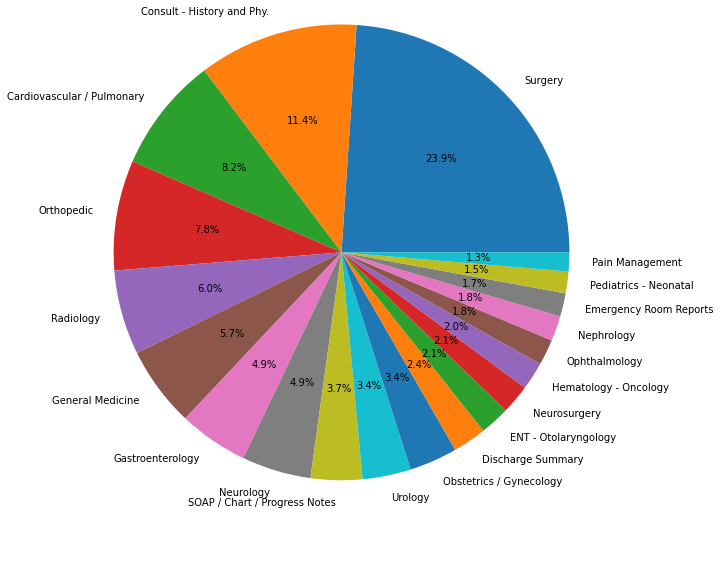

In [ ]:
cause_dist = full_data['medical_specialty'].value_counts()[0:20]
print(cause_dist)
plt.figure(figsize=(9,9))
plt.title(' ', y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis('equal')

**selected categories**

Cardiovascular / Pulmonary    371
Orthopedic                    355
Neurology                     317
Radiology                     273
Gastroenterology              224
Name: medical_specialty, dtype: int64


(-1.1238888937307316, 1.10113756636813, -1.1149502140560064, 1.113596635204414)

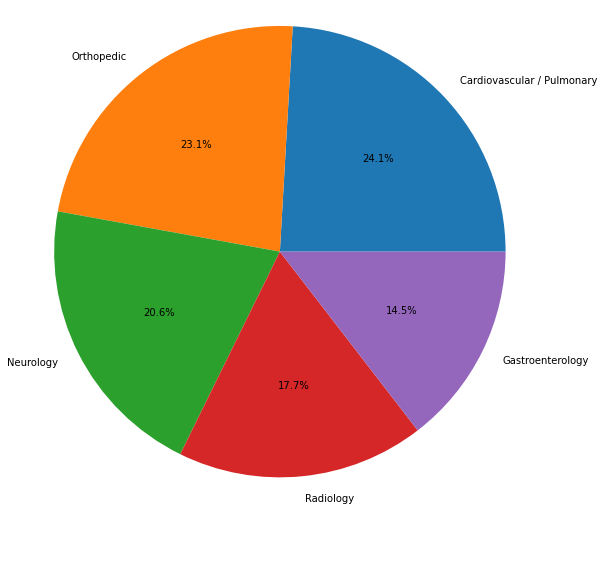

In [ ]:
cause_dist = data['medical_specialty'].value_counts()[0:top_categories_num]
print(cause_dist)
plt.figure(figsize=(9,9))
plt.title(' ', y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis('equal')

In [ ]:
print(data["description"][100])
print(data["transcription"][100])
print(data["medical_specialty"][100])

 mri left knee without contrast.
exam:,mri left knee without contrast,clinical:,left knee pain.,findings:,comparison is made with 10/13/05 radiographs.,there is a prominent suprapatellar effusion. patient has increased signal within the medial collateral ligament as well as fluid around it, compatible with type 2 sprain. there is fluid around the lateral collateral ligament without increased signal within the ligament itself, compatible with type 1 sprain.,medial and lateral menisci contain some minimal increased signal centrally that does not extend through an articular surface and findings are felt to represent minimal myxoid degeneration. no tear is seen. anterior cruciate and posterior cruciate ligaments are intact. there is a bone bruise of medial patellar facet measuring approximately 8 x 5 mm. there is suggestion of some mild posterior aspect of the lateral tibial plateau. mr signal on the bone marrow is otherwise normal.,impression:,type 2 sprain in the medial collateral ligame

**count words frequency in spesific class**

In [ ]:
B_class = data[data['medical_specialty'] == ' Bariatrics']["description"]
B_class_sentences = [sent.split() for sent in B_class]
B_class_sentences_combined = [inner for outer in B_class_sentences for inner in outer]

In [ ]:
Counter(B_class_sentences_combined)

Counter()

**count a spesific word frequency**

In [ ]:
full_data = ' '
for i in range(data.shape[0]):
   full_data += data["transcription"][i]

In [ ]:
Counter(full_data.split())

In [ ]:
ee = [True if "DESCRIPTION" in data["transcription"][i] else False for i in range(data.shape[0])]

In [ ]:
sum(ee)

480

**Histogram: Length of description sentences**

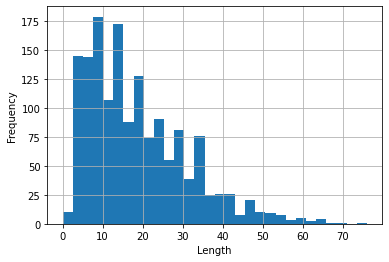

In [ ]:
# get length of all the sentences
seq_len = [len(data["description"][i].split()) for i in range(data.shape[0])]
pd.Series(seq_len).hist(bins = 30)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

**Histogram: Length of transcription sentences**

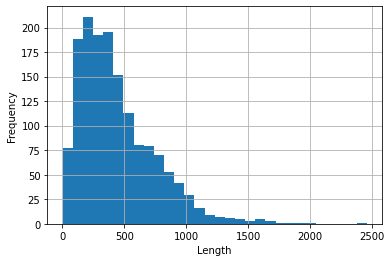

In [ ]:
seq_len = [len(data["transcription"][i].split()) for i in range(data.shape[0])]
pd.Series(seq_len).hist(bins = 30)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# see maybe to use LongTransformer (give bigger dim than 512): https://medium.com/dair-ai/longformer-what-bert-should-have-been-78f4cd595be9
MAX_SENTENCE_LENGTh = 70 # even tho we want 1500, the pretrained bert demands max size of 512...

## **Split data to train/validation/test sets**

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['description'], data['labels'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=data['labels'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
unseen_train_text, unseen_test_text, unseen_train_labels, unseen_test_labels = train_test_split(test_unseen_categories['description'], test_unseen_categories['labels'], 
                                                                random_state=42, 
                                                                test_size=0.2, 
                                                                stratify=test_unseen_categories['labels'])

## **Tokenize the texts**

Explaination about the tokenizer:

https://huggingface.co/course/chapter2/4?fw=pt

https://www.analyticsvidhya.com/blog/2021/09/an-explanatory-guide-to-bert-tokenizer/



In [ ]:
# Load the BERT tokenizer
model_name = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext' #('bert-base-uncased')   'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
tokenizer = BertTokenizerFast.from_pretrained(model_name) 

# Longformer toknizer
#model_name = "allenai/longformer-base-4096" 
#tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize and encode sequences in the sets set
texts = [train_text, val_text, test_text, unseen_train_text, unseen_test_text]
tokens_texts = []

for text in texts:
    tokens_texts.append(tokenizer.batch_encode_plus(text.tolist(),max_length = MAX_SENTENCE_LENGTh, padding='max_length', truncation=True))

train_tokinized, val_tokinized, test_tokinized, unseen_train_tokinized, unseen_test_tokinized = tokens_texts

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
# example of tokinze the text.
# 1 = Unkonwn symbol. check if there are many of them.
output = tokenizer.encode_plus(train_text[1519])
#print(output)
print(output.tokens)


<bound method BatchEncoding.tokens of {'input_ids': [2, 28382, 1956, 19668, 9782, 18, 7733, 7868, 16, 3659, 5199, 9581, 1927, 1920, 3614, 16, 3216, 3411, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}>


In [ ]:
def convert_to_tensors(data, labels):
  
    seq = torch.tensor(data['input_ids'])
    mask = torch.tensor(data['attention_mask'])
    y = torch.tensor(labels.tolist())

    return seq, mask, y

train_seq, train_mask, train_y  = convert_to_tensors(train_tokinized, train_labels)
val_seq, val_mask, val_y  = convert_to_tensors(val_tokinized, val_labels)
test_seq, test_mask, test_y  = convert_to_tensors(test_tokinized, test_labels)

unseen_train_seq, unseen_train_mask, unseen_train_y  = convert_to_tensors(unseen_train_tokinized, unseen_train_labels)
unseen_test_seq, unseen_test_mask, unseen_test_y  = convert_to_tensors(unseen_test_tokinized, unseen_test_labels)

## **Build custom data loaders**

In [ ]:
from torch.utils.data import Dataset, DataLoader


class ContrastiveDataset(Dataset):

    def __init__(self, train_seq, train_mask, train_y, positive_prob=0.5):

        super().__init__()
        self.train_seq = train_seq
        self.train_mask = train_mask
        self.train_y = train_y
        self.positive_prob = positive_prob # probability to sample two texts with the same category
        
        self.hash_table = {} # format: {"category" : [i1, i2, ...]}

        # construct a hash table, each key is a category
        # and the value is a list of the indexs of the texts which belong to this category 
        for i in range(len(self.train_seq)):
            label = self.train_y[i].item()
            if label in self.hash_table:
                self.hash_table[label].append(i)
            else:
                self.hash_table[label] = [i]
        

    def __getitem__(self, index):
        """
        Sample two texts from the same category with probability self.positive_prob
        :param index: index (int)
        :return:  seq_0 - a sequence of IDs (each ID represent a word in the vocabulary)
                  seq_1 - a sequence which differnt from seq0 (different text)
                  mask_0 - attention mask for seq1
                  mask_1 - attention mask for seq1
                  same_class - 1 if seq0 and seq1 are both from the same category, 0 otherwise
        """
        same_class = random.uniform(0, 1)
        same_class = same_class > self.positive_prob

        seq_0 = self.train_seq[index]
        mask_0 = self.train_mask[index]
        label_0 = self.train_y[index].item()
        class_samples = self.hash_table[label_0]

        if len(class_samples) < 2: # handle the case where there are only a single text in some category (in this case we can't draw another text from this category...)
            same_class = False

        if same_class:
            while True:                    
                rnd_idx = random.randint(0, len(class_samples) - 1)
                index_1 = class_samples[rnd_idx]
                if index_1 != index:
                    seq_1 = self.train_seq[index_1]
                    mask_1 = self.train_mask[index_1]
                    label_1 = self.train_y[index_1].item()
                    break
        else:
            while True:
                index_1 = random.randint(0, self.__len__() - 1)
                if index_1 != index:
                    seq_1 = self.train_seq[index_1]
                    mask_1 = self.train_mask[index_1]
                    label_1 = self.train_y[index_1].item()
                    if label_1 !=  label_0:
                        break

        return seq_0, seq_1, mask_0, mask_1, torch.tensor(same_class, dtype=torch.float)

    def __len__(self):
        return len(self.train_seq)

class SimpleDataset(Dataset):

    def __init__(self, seq, mask, y, positive_prob=0.5):

        super().__init__()
        self.seq = seq
        self.mask = mask
        self.y = y


    def __getitem__(self, index):
        """
        Sample texts by the order of the training set.
        :param index: index (int)
        :return: seq - a sequence of IDs (each ID represent a word in the vocabulary)
                 mask - attention mask for seq
                 y - the category of this text
                        
        """
        return   self.seq[index], self.mask[index], torch.tensor(self.y[index].item())

    def __len__(self):
        return len(self.seq)

In [ ]:
train_set = ContrastiveDataset(train_seq, train_mask,  train_y)
val_set = ContrastiveDataset(val_seq, val_mask, val_y)
test_set = ContrastiveDataset(test_seq, test_mask,test_y)

train_set_simple = SimpleDataset(train_seq, train_mask,  train_y)
test_set_simple = SimpleDataset(test_seq, test_mask,  test_y)
unseen_train_set_simple = SimpleDataset(unseen_train_seq, unseen_train_mask,  unseen_train_y)
unseen_test_set_simple = SimpleDataset(unseen_test_seq, unseen_test_mask,  unseen_test_y)

In [ ]:
trainLoader = DataLoader(train_set, batch_size=32, shuffle=True,  drop_last=False, num_workers=0)
valLoader = DataLoader(val_set, batch_size=32, shuffle=True,  drop_last=False, num_workers=0)
testLoader = DataLoader(test_set, batch_size=10, shuffle=False,  drop_last=False, num_workers=0)

trainLoader_simple = DataLoader(train_set_simple, batch_size=32, shuffle=False,  drop_last=False, num_workers=0)
testLoader_simple = DataLoader(test_set_simple, batch_size=64, shuffle=False,  drop_last=False, num_workers=0)
unseen_trainLoader_simple = DataLoader(unseen_train_set_simple, batch_size=64, shuffle=False,  drop_last=False, num_workers=0)
unseen_testLoader_simple = DataLoader(unseen_test_set_simple, batch_size=64, shuffle=False,  drop_last=False, num_workers=0)

# **Siamese Transformer Network**

https://www.kaggle.com/sauravjoshi23/text-classification-using-siamesenet-glove

-- Build a Encoder of Transformer (it by itself perform embedding by learning the embedding. another option: feed to it a predefined embedding, as word2vec/glove).

 input: words of a sentence, output: vec meaning for each word

https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec

https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

sieams
https://www.mdpi.com/2076-3417/10/12/4176/htm

Text Classification using SiameseNet+Glove
https://www.kaggle.com/sauravjoshi23/text-classification-using-siamesenet-glove


-- Move the resilts vectors to dense layer, resulting of 1 vec that represnts the sentence



ides taken from:

from [here](https://www.mdpi.com/2076-3417/10/12/4176/htm) we take the idea of prototypes, and hence we learning the disimilarty using another FF layer (instead of usig a constrative loss, we calculate the dis in the network itself). this paper diplay image classification, while we do text classification.

from [here](https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/) we take the idea of transfer learning (we use pretrained transformer from "facehugg" libary + another layer of FF) --> this part responsible to learn the feature vectors.


* the original siems is based on convolution network, ours is based on transformer since our data is text and not images.
* we use a pretrained transfor (facehugg libary) + adding a FF layer that we fine tune.
* sieams network return for each input (sentence) a "feature vector" which represent the sentence (in the spectugrams they used feature vector of 4096 dimension. We use 512 since our data is text an not images, so maybe need smaller feature vector)
* the dissimiarty is learned by another FF layer followd by sigmoid (isnted of the original siema network, that use consractive loss)
* the final output of a siem network is a scalar number (between 0 and 1?) which represents the dissimilarty between the two input sentences.
* we use BCE loss and not consractive loss, since we need that the network will return already a dis value, cuz we use it when we project the data with the prototypes.



sentence1 --> Transformer --> feature vec (dim 768) --> FF layer (fine-tune) --> feature vec (dim 512)

sentence2 --> Transformer --> feature vec (dim 768) --> FF layer (fine-tune) --> feature vec (dim 512)


feature vec

            ---- > absolute difference --> distance_layer ---> sigmoid (convert to a number of range [0,1] ---> dissimilarty value

feature vec





In [ ]:
input = torch.randn(32, 70, 768).permute(0, 2, 1).contiguous() #הThe .contiguous() ensures the memory of the tensor is stored contiguously which helps avoid potential issues during processing.
print(input.shape)
m = nn.Conv1d(in_channels=768, out_channels=1, kernel_size=3, stride=1) # kernal size of size n = n grams
outputt = m(input)

print(outputt.shape)

torch.Size([32, 768, 70])
torch.Size([32, 1, 68])


In [ ]:
fine_tuning_hs = nn.Sequential(
                            nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, stride=1), # Output shape: (b, 128, *) # kernal_size=3 == three-grams, * depends on kernel size and padding
                            nn.ReLU(),
                            nn.AvgPool1d(kernel_size=2),                                           # Output shape: (b, 128, *)
                            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=4, stride=1), # Output shape: (b, 128, *)
                            nn.ReLU(),
                            nn.MaxPool1d(kernel_size=2),                                            # Output shape: (b, 128, 1)
                            nn.Flatten(),                                                          # Output shape: (b, sum(num_filters))
                            nn.Linear(128,128),                                                    # Output shape: (b, 128)
                            nn.Dropout(0.2)
                            )


input = torch.randn(32, 70, 768).permute(0, 2, 1).contiguous()
print(input.shape)
outputt = F.relu(nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, stride=1)(input))
print(outputt.shape)
outputt = nn.ReLU()(outputt)
print(outputt.shape)
outputt = nn.AvgPool1d(kernel_size=2)(outputt)
print(outputt.shape)
outputt = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=4, stride=1)(outputt)
print(outputt.shape)
outputt = nn.ReLU()(outputt)
print(outputt.shape)
outputt = nn.MaxPool1d(kernel_size=outputt.shape[2])(outputt)
print(outputt.shape)
outputt = nn.Flatten()(outputt)
print(outputt.shape)

torch.Size([32, 768, 70])
torch.Size([32, 128, 68])
torch.Size([32, 128, 68])
torch.Size([32, 128, 34])
torch.Size([32, 128, 31])
torch.Size([32, 128, 31])
torch.Size([32, 128, 1])
torch.Size([32, 128])


In [ ]:
# (728, 512) (512, 128)  distance: (128, 1)

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 

      # For cls_hs output (First token embedding)

      #self.fc1 = nn.Linear(768,512)
      #self.dropout = nn.Dropout(0.1)
      #self.relu =  nn.ReLU()
      #self.fc2 = nn.Linear(512,128)

      # For hs output (all tokens embeddings)
      # https://chriskhanhtran.github.io/posts/cnn-sentence-classification/
      self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, stride=1) # kernal_size=3 == three-grams
      self.avg_pooling = nn.AvgPool1d(kernel_size=2)                                        
      self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1) 
      self.flatten = nn.Flatten()                                                          
      self.fc = nn.Linear(64,128)                                                    
      self.dropout = nn.Dropout(0.2)

      # Other options:
      #Mean of the token embeddings
      #Max of the token embedding
      


    def forward(self, seq, mask):
      
      # Explaination on BERT and its outputs:
      # https://towardsdatascience.com/tips-and-tricks-for-your-bert-based-applications-359c6b697f8e
      # To sum up: BERT is a transformer encoder, meanning it produces representations of the inputs, and hence we can use it for several tasks.

      # BERT returns a dictionary of vectors where the first is called 'sequence output' (or 'hidden state'=hs) and the other is 'pooled output' (or 'cls_hs').
      # ** 'sequence_output' is of shape [batch_size, max_seq_length, 768] with representations for each input token (including start symbol and end symbol)
      # ** 'pooled_output' is of shape [batch_size, 768] with representations for the entire input sequences. It created by taking only the first token embedded vector (start symbol)
      #     (and pass it throgh more layers (?))
      
      # The idea of "pooled_output":
      # Since, the embeddings from the BERT model at the output layer are known to be contextual embeddings, the output of the 1st token, i.e, [CLS] token
      # would have captured sufficient context. Hence, the authors of BERT paper found it sufficient to use only the output from the 1st token for few tasks
      # such as classification. They call this output from the single token (i.e, 1st token) as pooled_output.

      # Get embeddings from bert. 
      # Output shape: hs = (b, max_len_seq, embed_dim)           
      #               cls = (b, embed_dim)
      # where:  b: batch_size
      #         max_len_seq=number of tokens in the longest text (we defined it erilier)
      hs, cls_hs = self.bert(seq, attention_mask=mask, return_dict=False) 
   
      #x = self.fc1(cls_hs)
      #x = self.dropout(x)
      #x = self.relu(x) 
      #x = self.fc2(x) 

     
      x = hs.permute(0, 2, 1).contiguous()          # Permute `hs` to match input shape requirement of `nn.Conv1d`
                                                    # The contiguous() ensures the memory of the tensor is stored contiguously
                                                    # which helps avoid potential issues during processing.
                                                    # Output shape: (b, 768, 70) = (b, embed_dim, max_len_seq).        
      
      x = F.relu(self.conv1(x))                     # Output shape: (b, 128, *)  * depends on kernel size and padding
      x = self.avg_pooling(x)                       # Output shape: (b, 128, *)
      x = F.relu(self.conv2(x))                     # Output shape: (b, 128, *)
      x = F.max_pool1d(x, kernel_size=x.shape[2])   # Output shape: (b, 128, 1) # trick: we use kernel of size x.shape[2] to reduce from * to 1
      x = self.flatten(x)                           # Output shape: (b, 128)
      x = self.fc(x)                                # Output shape: (b, 128)
      x = self.dropout(x) 
    
      return x


class SiameseNeuralNetwork(nn.Module):
    
    def __init__(self, bert_arch):
        super().__init__()            # TODO super?

        self.bert_arch = bert_arch
        self.distance_layer = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())  # if we would use BCEWithLogitsLoss as loss function, we should delte the sigmoid since we dont need it after the linear layer a sigmoid layer                                  


    def forward(self, seq1, seq2, mask1, mask2):
        feature_vec1 = self.bert_arch(seq1, mask1) # feature_vec1 shape:  [batch_size, embedding_size]
        feature_vec2 = self.bert_arch(seq2, mask2)
        difference = torch.abs(feature_vec1 - feature_vec2)  
        out = self.distance_layer(difference)
        return out #feature_vec1, feature_vec2#out


class ContrastiveLoss(nn.Module):
    """
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() *  torch.nn.functional.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


In [ ]:
# Train procedure: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code

def train_siamese_network(model, dataloaders, num_epochs, device): 
    """
    Train the given SNN model.

    :param model: SNN model
    :param dataloaders: a dict that contains train data loader and validation data loader
    :param num_epochs: number of epochs
    :param device: 'cpu' or 'cuda' 

    :return:  train_loss_history - list of train losses by epochs
              val_loss_history -  list of validation losses by epochs

    """
    train_loss_history = []
    val_loss_history = []
    matching_similarity = []
    non_matching_similarity = []

    val_matching_similarity = []
    val_non_matching_similarity = []

    criterion = torch.nn.BCELoss(reduction='mean') #ContrastiveLoss(margin=1)  #losses.ContrastiveLoss(pos_margin=0, neg_margin=1) # torch.nn.BCEWithLogitsLoss(reduction='mean') # the labels are same class (1) vs. different class (0)
    learning_rate = 0.005 # 0.005 # 0.1
    optimizer  =  AdamW(model.parameters(),lr =learning_rate)#torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # AdamW(model.parameters(),lr =learning_rate)  1e-5
    
    # lr = lr * factor 
    # mode='min': look for the min validation loss to track
    # patience: number of epochs - 1 where loss plateaus before decreasing LR
    # patience = 0, after 1 bad epoch, reduce LR
    # factor: decaying factor

    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True, min_lr=0.0001)  ########################################################
    #cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.1, cycle_momentum=False) ########################################################

    for epoch in range(num_epochs):  # loop over the train dataset multiple times

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
  
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0

            for i, batch in enumerate(dataloaders[phase]):

                  seq1, seq2, mask1, mask2, label = batch

                  if device == 'cuda':
                    seq1, seq2, mask1, mask2, label = seq1.to(device), seq2.to(device), mask1.to(device), mask2.to(device), label.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()
                  
                  # track history  only in train
                  with torch.set_grad_enabled(phase == 'train'):

                      # forward 
                      output = model.forward(seq1, seq2, mask1, mask2) 
                      loss = criterion(output, label.view(output.size())) # criterion(output.squeeze(0), label.view(1))    label.view((trainLoader.batch_size,1))
                      
                      # backward + optimize only if in training phase
                      if phase == 'train': #  with torch.no_grad() if phae == 'val'?
                          loss.backward()
                          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
                          optimizer.step()
                          #cyclic_scheduler.step() ########################################################

                          # save similarity scores for training data
                          output = output.cpu().detach().numpy()
                          label = label.cpu().numpy()
                          non_matching_similarity.append((sum(output[label == 0]) / sum(label == 0)).item())
                          matching_similarity.append((sum(output[label == 1]) / sum(label == 1)).item())
                     
                      if phase == 'val':
                         val_non_matching_similarity.append((sum(output[label == 0]) / sum(label == 0)).item())
                         val_matching_similarity.append((sum(output[label == 1]) / sum(label == 1)).item())

                  running_loss += loss.item() * seq1.size(0)  #we multiply by the batch size (note that the batch size in the last batch may not be the batch size we did since the batch size dont necceraly divide the train size)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
               train_loss_history.append(epoch_loss) 
            else:
               val_loss_history.append(epoch_loss)
               #scheduler.step(epoch_loss) ########################################################

            print('Epoch {} | {} loss: {:.3f}'.format(epoch, phase, epoch_loss))
            
                  
    return train_loss_history, val_loss_history, [non_matching_similarity, matching_similarity, val_non_matching_similarity, val_matching_similarity]

    

In [ ]:
# specify GPU
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# import BERT-base pretrained model
bert = AutoModel.from_pretrained(model_name)   # ('bert-base-uncased') 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# pass the pre-trained BERT to our define architecture
bert_arch = BERT_Arch(bert)

SNN_model = SiameseNeuralNetwork(bert_arch).to(device)
num_epochs = 30

train_loss_history, val_loss_history, similarities_list = train_siamese_network(SNN_model, dataloaders={"train":trainLoader, "val":valLoader},  num_epochs=num_epochs, device=device)

non_matching_similarity, matching_similarity, val_non_matching_similarity, val_matching_similarity = similarities_list

Using cuda device


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0 | train loss: 0.697
Epoch 0 | val loss: 0.632
Epoch 1 | train loss: 0.646
Epoch 1 | val loss: 0.616
Epoch 2 | train loss: 0.618
Epoch 2 | val loss: 0.705
Epoch 3 | train loss: 0.612
Epoch 3 | val loss: 0.566
Epoch 4 | train loss: 0.597
Epoch 4 | val loss: 0.639
Epoch 5 | train loss: 0.573
Epoch 5 | val loss: 0.676
Epoch 6 | train loss: 0.562
Epoch 6 | val loss: 0.549
Epoch 7 | train loss: 0.544
Epoch 7 | val loss: 0.604
Epoch 8 | train loss: 0.565
Epoch 8 | val loss: 0.628
Epoch 9 | train loss: 0.568
Epoch 9 | val loss: 0.608
Epoch 10 | train loss: 0.581
Epoch 10 | val loss: 0.537
Epoch 11 | train loss: 0.560
Epoch 11 | val loss: 0.578
Epoch 12 | train loss: 0.542
Epoch 12 | val loss: 0.541
Epoch 13 | train loss: 0.525
Epoch 13 | val loss: 0.590
Epoch 14 | train loss: 0.531
Epoch 14 | val loss: 0.631
Epoch 15 | train loss: 0.531
Epoch 15 | val loss: 0.568
Epoch 16 | train loss: 0.552
Epoch 16 | val loss: 0.597
Epoch 17 | train loss: 0.532
Epoch 17 | val loss: 0.523
Epoch 18 | t

**loss doenst decrease:**

https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn

https://livebook.manning.com/concept/deep-learning/training-loss

https://www.quora.com/What-usually-causes-a-neural-network-to-stop-improving-early

https://www.quora.com/What-should-I-do-when-my-neural-network-doesnt-learn

In [ ]:
torch.save(SNN_model.state_dict(), "SNN_model")

#Later to restore:
SNN_model =
SNN_model.load_state_dict(torch.load("SNN_model"))

SyntaxError: ignored

**Plot Losses**

Why is my validation loss lower than my training loss?

https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/

 Loss Pleateau

 https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

 https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/#pointers-on-reduce-on-loss-pleateau-decay

In [ ]:
def plot_losses(train_loss_history, val_loss_history, num_epochs):
    
    fig = go.Figure()

    line_color = [px.colors.qualitative.Light24[5], px.colors.qualitative.Light24[4]] 


    fig.add_trace(go.Scatter(x=list(range(1, num_epochs+1)), y=train_loss_history, mode='lines', line=dict(color=line_color[0], width=1), name="train loss"))
    fig.add_trace(go.Scatter(x=list(range(1, num_epochs+1)), y=val_loss_history, mode='lines',line=dict(color=line_color[1], width=1), name="valdiation loss")) #opacity=0.8

    fig.update_yaxes(range=[0, 1])
    fig.update_traces(textposition='top center')
    fig.update_layout(autosize=False,width=900, height=500, title_text="SNN Loss", title_x=0.5, xaxis_title="Epoch", yaxis_title="", xaxis = dict(tickmode='linear', tick0=1, dtick=1), legend=dict(yanchor="top",xanchor="right", x=1.35, y=1),template="plotly_dark")
    fig.show()

In [ ]:
plot_losses(train_loss_history, val_loss_history, num_epochs)

In [ ]:
def plot_similarity_scores(non_matching_similarity, matching_similarity):

    train_num_batchs = len(non_matching_similarity)
    
    fig = go.Figure()

    line_color = [px.colors.qualitative.Light24[22], px.colors.qualitative.Light24[19]] 


    fig.add_trace(go.Scatter(x=list(range(1, train_num_batchs+1)), y=non_matching_similarity, mode='lines', line=dict(color=line_color[0], width=1), name="unmatching categories"))
    fig.add_trace(go.Scatter(x=list(range(1, train_num_batchs+1)), y=matching_similarity, mode='lines',line=dict(color=line_color[1], width=1), name="matching categories")) #opacity=0.8

    fig.update_yaxes(range=[0, 1])
    fig.update_traces(textposition='top center')
    fig.update_layout(autosize=False,width=900, height=500, title_text="Similarity Scores", title_x=0.5, xaxis_title="Batch", yaxis_title="", legend=dict(yanchor="top",xanchor="right", x=1.35, y=1),template="plotly_dark")
    fig.show()

In [ ]:
plot_similarity_scores(non_matching_similarity, matching_similarity)

In [ ]:
plot_similarity_scores(val_non_matching_similarity, val_matching_similarity)

In [ ]:
print(len(non_matching_similarity))

1020


 **print all layers in the model that are participating in the learning process**


In [ ]:
# print all layers in the model that are participating in the learning process
for name, param in SNN_model.named_parameters():
    if param.requires_grad:
        print(name)

In [ ]:
SNN_model.bert_arch.fc1.weight.shape

In [ ]:
SNN_model.bert_arch.fc1.bias.shape

# **Prototypes Selection**

In [ ]:
from multiprocessing import Pool

def f(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(f, [1, 2, 3]))

[1, 4, 9]


In [ ]:
SNN_model.bert_arch.fc

In [ ]:
def construct_train_matrix(SNN_model, trainLoader_simple):
    """
    Embed the training data using the trained SNN model.
    """

    # Get intermidate layer output.
    # Source: https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/2
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # SNN_model.bert_arch.fc1.register_forward_hook(get_activation('fc1'))
    SNN_model.bert_arch.fc.register_forward_hook(get_activation('fc'))

    train_matrix = []
    print("num batches:", len(trainLoader_simple))
    with torch.no_grad():            
        for i, batch in enumerate(trainLoader_simple):
            print(i, "/", len(trainLoader_simple), " batches")
            seq1, mask1, label1 = batch
            if device == 'cuda':
                seq1, mask1, label1 = seq1.to(device), mask1.to(device), label1.to(device)

            SNN_model.eval()
            output = SNN_model(seq1, seq1, mask1, mask1)
            train_matrix.append(activation['fc'].cpu().numpy()) # activation['fc1'] return a tensor in cuda with size (batch_size, embedding_dim), so we move it to cpu, than to numpy array.

    return np.vstack(train_matrix) # we combine all the batches, so now we return matrix of size (num_samples_train, embedding_dim)

def extract_prototypes(k, SNN_model, trainLoader_simple, train_labels, train_matrix):
    """
    Compute kc (= k/num_classes_train) prototypes for each class in the trainset.
    (if k % num_classes_train != 0 then take the highest k0 <= k which is divisable by num_classes_train)

    :param k: 
    :param train_matrix: size (num_samples_train, embedding_dim)
    :return: 
    """
    train_labels = list(train_labels)
    train_dataset = trainLoader_simple.dataset  # contains triples of (seq, mask, label)

    # construct a hash table, each key is a class of diagnosis
    # and the value is a list of the indexs of the sentences which belong to this class 
    hash_table = {} # format: {"diagnosis" : [i1, i2, ...]}
    for i in range(len(train_labels)):
        lbl = train_labels[i]
        if lbl in hash_table:
            hash_table[lbl].append(i)
        else:
            hash_table[lbl] = [i]


    # Create prototypess
    prototypes_list = {diagnosis:[] for diagnosis in hash_table.keys()}
    num_classes_train = len(hash_table)
    assert k >= num_classes_train, "k should be greater than the numbrer of uniqe labels in the train set'"
    kc = int(k / num_classes_train)
    print("kc:", kc)

    for diagnosis in hash_table.keys():

      print("diagnosis:", diagnosis)

      if len(hash_table[diagnosis]) <= 1 : # if there is only a single sentence in some diagnosis sentences list - take it as the prototype of this class
          prototypes_list += list(train_matrix[hash_table[diagnosis]])
          
      else:
          # fit on all sentences which belongs to the same class (diagnosis)
          kmeans = KMeans(n_clusters=kc, init='k-means++').fit(train_matrix[hash_table[diagnosis]]) 
          # extract for each centroid the closest real sample, and add it as a prototype
          for centroid in kmeans.cluster_centers_:
             #print(train_matrix[hash_table[diagnosis]].shape)
             best_match_index = None
             best_match_dist = float('inf')
             for sentence_index in hash_table[diagnosis]:
                 #print(sentence_index)
                 embedded_sent = train_matrix[sentence_index]
                 dist = distance.euclidean(centroid, embedded_sent)
                 #print("dist:", best_match_dist)
                 if dist < best_match_dist:
                    best_match_dist = dist
                    best_match_index = sentence_index
             #print(best_match_index)
             prototypes_list[diagnosis].append(train_dataset[best_match_index])
    
    return prototypes_list



In [ ]:
train_matrix = construct_train_matrix(SNN_model, trainLoader_simple)


num batches: 34
0 / 34  batches
1 / 34  batches
2 / 34  batches
3 / 34  batches
4 / 34  batches
5 / 34  batches
6 / 34  batches
7 / 34  batches
8 / 34  batches
9 / 34  batches
10 / 34  batches
11 / 34  batches
12 / 34  batches
13 / 34  batches
14 / 34  batches
15 / 34  batches
16 / 34  batches
17 / 34  batches
18 / 34  batches
19 / 34  batches
20 / 34  batches
21 / 34  batches
22 / 34  batches
23 / 34  batches
24 / 34  batches
25 / 34  batches
26 / 34  batches
27 / 34  batches
28 / 34  batches
29 / 34  batches
30 / 34  batches
31 / 34  batches
32 / 34  batches
33 / 34  batches


In [ ]:
prototypes_list = extract_prototypes(100, SNN_model, trainLoader_simple, train_labels, train_matrix)

kc: 20
diagnosis: 26
diagnosis: 21
diagnosis: 3
diagnosis: 11
diagnosis: 18


**Display train data in 3D**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding

def show_space(X, title, colors=None, color_by="", show_3D=False):

  if show_3D:
    dictionary = dict(zip(pd.DataFrame(X).columns, ["COMP1", "COMP2", "COMP3"]))
    temp_df = pd.DataFrame(X).rename(columns=dictionary)
    fig = px.scatter_3d(temp_df, x='COMP1', y='COMP2', z='COMP3',color=colors, template="plotly_dark", labels={"color": color_by})
  else:
    dictionary = dict(zip(X.columns, ["COMP1", "COMP2"]))
    temp_df = pd.DataFrame(X).rename(columns=dictionary)
    fig = px.scatter(temp_df, x='COMP1', y='COMP2',color=colors, template="plotly_dark", labels={"color": color_by})

  fig.update_traces(marker=dict(size=4, opacity=0.98), textposition='top center')
  fig.update_layout(title_text=title, title_x=0.5, autosize=False,width=900, height=500, legend=dict(yanchor="top",xanchor="right", x=1.1, y=1))
  fig.show()
  #fig.write_html("file.html")

In [ ]:
pca_alg = PCA(n_components=3)
X_pca = pca_alg.fit_transform(train_matrix) 
show_space(X_pca, title="3D Space", colors=pd.DataFrame(train_labels).replace(categories_mapping), color_by="category", show_3D=True)

In [ ]:
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.67148525 0.19894294 0.05936258]
Comulative explained variance: [0.67148525 0.8704282  0.9297908 ]


In [ ]:
# pca total variance of first 3 components

# **Projection**

In [ ]:
def project_to_dissimilarity_space(dataLoader, SNN_model, prototypes_list):
    """
    
    Parameters
    ----------
    dataLoader : 
    SNN_model : 

    
    Returns
    -------
    projected_data : numpy array of shape (num_samples_data, projection_dim)
    """

    projected_data = [] 
    with torch.no_grad():     
               
        for batch in dataLoader:
            print("****new batch***")

            projected_sentence = []
            seq1, mask1, label1 = batch
            if device == 'cuda':
                seq1, mask1, label1 = seq1.to(device), mask1.to(device), label1.to(device)

            for diagnosis in prototypes_list:
                #print("diagnosis:", diagnosis)
                for centroid in prototypes_list[diagnosis]: # centroid contains a triple of (seq, mask, label)
                    seq2, mask2 = centroid[0].repeat(seq1.shape[0], 1), centroid[1].repeat(mask1.shape[0], 1)  # we stack to seq2 and mask2 replications of them such that they will fit the batch size of seq1 and mask2
                    if device == 'cuda':
                       seq2, mask2 = seq2.to(device), mask2.to(device)

                    SNN_model.eval()
                    distance = SNN_model(seq1, seq2, mask1, mask2)
                    projected_sentence.append(distance.squeeze().cpu().numpy())
            
            projected_data.append(np.array(projected_sentence).T)
            #break # TODO delete

    projected_data = np.vstack(projected_data)
    return projected_data

In [ ]:
projected_train = project_to_dissimilarity_space(trainLoader_simple, SNN_model, prototypes_list)

****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***


In [ ]:
projected_train.shape

(1078, 100)

In [ ]:
X_pca = pca_alg.fit_transform(projected_train) 
show_space(X_pca, title="3D Space", colors=pd.DataFrame(train_labels).replace(categories_mapping), color_by="category", show_3D=True)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.5718724  0.22398916 0.11776582]
Comulative explained variance: [0.5718724  0.7958616  0.91362745]


# **SVM**

In [ ]:
def ensemble_of_classifiers(projected_train,  train_y):
    """
    For each category a classifier is trained to discriminate between this category and all the other categories put together.
    
    Parameters
    ----------
    projected_train : shape (num_samples_train, projection_dim)
    train_y : shape (num_samples_train)

    
    Returns
    -------
    classifiers_list : a list of trained classifiers. The it'h classifier desined to predict the i'th category. 
    diagnosis_list : list of the categories order as the classifiers. 
    """

    classifiers_list = []

    diagnosis_list = np.sort(list(Counter(list(train_y)).keys()))   # orderd by increasing order: (0,1,2,..)

    for diagnosis in diagnosis_list:
        print(diagnosis)
        
        y = np.zeros(len(train_y))
        is_diagnosis = train_y == diagnosis
        y[is_diagnosis] = 1
        y = y.astype('int')
        if y.sum() == 0: # TODO delete
          continue
        classifier = SVC(gamma='auto', probability=True)
        classifier.fit(projected_train, y)

        classifiers_list.append(classifier)

    return classifiers_list, diagnosis_list



In [ ]:
from sklearn.svm import SVC

classifiers, categories_order = ensemble_of_classifiers(projected_train,  train_labels)

3
11
18
21
26


In [ ]:
print(len(classifiers))

5


# **Test** - Seen categories

In [ ]:
projected_test = project_to_dissimilarity_space(testLoader_simple, SNN_model, prototypes_list)

****new batch***
****new batch***
****new batch***
****new batch***


In [ ]:
projected_test.shape

(231, 100)

In [ ]:
X_pca = pca_alg.fit_transform(projected_test) 
show_space(X_pca, title="3D Space", colors=pd.DataFrame(test_labels).replace(categories_mapping), color_by="category", show_3D=True)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.5856723  0.19591992 0.109155  ]
Comulative explained variance: [0.5856723  0.78159225 0.89074725]


In [ ]:
def predict(projected_test, classifiers_list, categories_order, test_labels):

    pred_y = []
     
    for classifier in classifiers_list:
         pred_y.append(classifier.predict_proba(projected_test)[:,1])    # predict_proba returns probabiltiy for class==0 and for class==1, so we take only the probabilities of class==1
    
    pred_y = np.vstack(pred_y) # (num_classifiers, num_samples_test)
    highest_predictions = categories_order[np.argmax(pred_y, axis=0)]
    print(pred_y)
    print(highest_predictions)
    return highest_predictions
       


In [ ]:
preds = predict(projected_test, classifiers, categories_order, test_labels)

[[9.06497518e-01 4.22945484e-02 9.27972309e-01 ... 9.91558353e-03
  8.29207502e-03 9.44201879e-01]
 [3.17179475e-04 7.99165297e-01 2.41063025e-03 ... 4.50768144e-03
  3.92028214e-03 6.13502205e-04]
 [7.86471885e-02 3.16745531e-02 3.57406547e-02 ... 9.97267539e-02
  7.16640304e-01 3.55695892e-02]
 [4.13659613e-02 2.78985410e-02 2.95260976e-02 ... 7.18281033e-01
  1.45186659e-02 3.10082280e-02]
 [1.26413458e-01 1.16556337e-01 1.06317467e-01 ... 1.32821917e-01
  2.14410045e-01 1.22298769e-01]]
[ 3 11  3 18  3 21 18 11 21 18 21 18 18 18 18 26 21 18 18  3  3 11  3 18
 18  3  3 21  3 21 21 18 26 18 26  3  3 21 11 11 21  3 21 18 21  3 26 18
 18  3  3 11 21  3 11  3 21 21 18  3 21 18 18 21  3 18  3 18 11  3 21  3
 21 18 11 21  3  3 18  3 18  3 21 11 21  3  3  3 18 21  3 26 11 11 21 21
 18 26 21 18 11  3 18 18 26 26  3  3 21 21 11 26 21 26 21 18 18  3 21  3
 21 18 21 21 11 11 11 26  3 26  3 11  3 21 21 21  3 18 11 18  3 18  3  3
 18 26  3 18 21 26 18 21  3 21  3 26  3 21 26 26 21  3 26 21 18  3

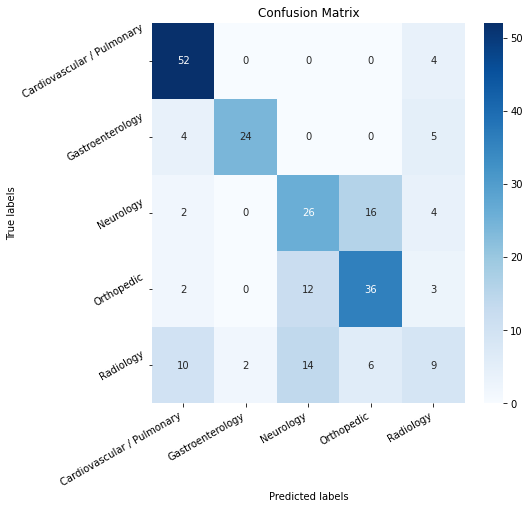

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(mat,fig_size, labels):

    fig = plt.figure(figsize=(fig_size,fig_size))
    ax= fig.add_subplot(1,1,1)
    sns.heatmap(mat, annot=True, cmap="Blues",ax = ax,fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
    plt.show()

c_matrix = confusion_matrix(test_labels, preds)
plot_confusion_matrix(c_matrix, fig_size=7, labels=[categories_mapping[c] for c in categories_order])

In [ ]:
from sklearn.metrics import classification_report
categories_labels = [categories_mapping[c] for c in categories_order]
print(classification_report(test_labels, preds, target_names=categories_labels))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.74      0.93      0.83        56
          Gastroenterology       0.92      0.73      0.81        33
                 Neurology       0.50      0.54      0.52        48
                Orthopedic       0.62      0.68      0.65        53
                 Radiology       0.36      0.22      0.27        41

                  accuracy                           0.64       231
                 macro avg       0.63      0.62      0.62       231
              weighted avg       0.62      0.64      0.62       231



# **Test** - Unseen categories

In [ ]:
unseen_train_matrix = construct_train_matrix(SNN_model, unseen_trainLoader_simple)
unseen_prototypes_list = extract_prototypes(100, SNN_model, unseen_trainLoader_simple, unseen_train_labels, unseen_train_matrix)
unseen_projected_train = project_to_dissimilarity_space(unseen_trainLoader_simple, SNN_model, unseen_prototypes_list)
unseen_classifiers, unseen_categories_order = ensemble_of_classifiers(unseen_projected_train,  unseen_train_labels)

num batches: 10
0 / 10  batches
1 / 10  batches
2 / 10  batches
3 / 10  batches
4 / 10  batches
5 / 10  batches
6 / 10  batches
7 / 10  batches
8 / 10  batches
9 / 10  batches
kc: 12
diagnosis: 30
diagnosis: 19
diagnosis: 17
diagnosis: 9
diagnosis: 12
diagnosis: 25
diagnosis: 22
diagnosis: 20
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
9
12
17
19
20
22
25
30


In [ ]:
unseen_projected_test = project_to_dissimilarity_space(unseen_testLoader_simple, SNN_model, unseen_prototypes_list)
unseen_preds = predict(unseen_projected_test, unseen_classifiers, unseen_categories_order, unseen_test_labels)



****new batch***
****new batch***
****new batch***
[[0.13516332 0.11761123 0.0899896  ... 0.1198466  0.07635645 0.06433335]
 [0.11573274 0.11413227 0.1137885  ... 0.11313168 0.11453109 0.11515506]
 [0.08127978 0.10720222 0.09822605 ... 0.17820996 0.01015258 0.06119408]
 ...
 [0.1293576  0.08853877 0.09636341 ... 0.07968307 0.08177174 0.08200888]
 [0.01948808 0.0194217  0.01577369 ... 0.03695012 0.07372426 0.01107365]
 [0.14440057 0.18258117 0.17624414 ... 0.20070883 0.1626611  0.23553353]]
[19 19 19 30  9  9 19  9 19 19 30 19 30 19 17  9  9 19  9 30  9 19 30 20
 19 30 30 19 30  9 20 19 19 19 30 20 30 19 30  9 30 19  9 30 30 30 19 19
 20 30  9 30 20  9 20 30 19 30  9 17 17 19 19  9 19 25 30  9 30 30 30 19
 20 30 17 30 20 30 19 19 19 19 30 19 19 30 30 20  9 19 30 20 19 19 30 30
 20 30  9 19 30 19 30 19 19 17 19 20 19 30 19 22 19 17  9 19 17  9 30 19
 30 30 30 20 30 30 30 30 19 30 19 19 20 19  9 17 19 19 19 30 19  9 19 19
  9 19 19 19 30 19 19 19 19 19 30 19 30]


In [ ]:
len(unseen_projected_test)

157

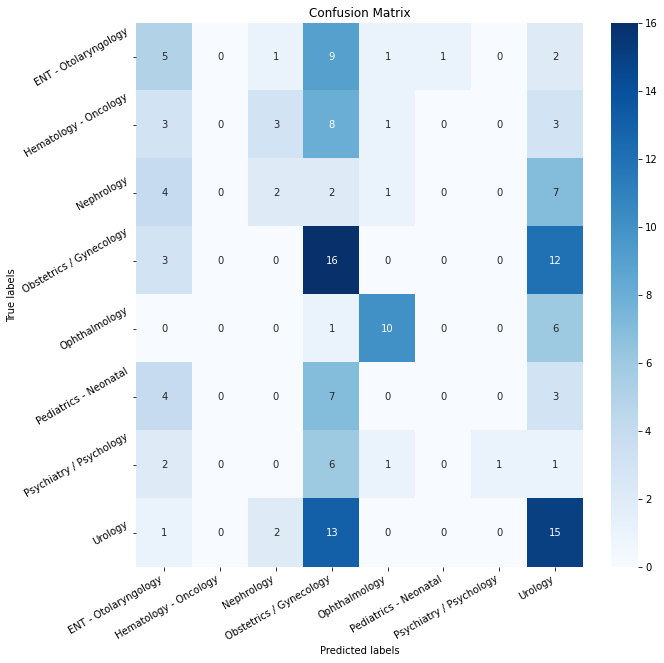

In [ ]:
unseen_c_matrix = confusion_matrix(unseen_test_labels, unseen_preds)
plot_confusion_matrix(unseen_c_matrix, fig_size=10, labels=[unseen_categories_mapping[c] for c in unseen_categories_order])

In [ ]:
Counter(unseen_train_labels)

Counter({0: 6,
         1: 6,
         2: 14,
         4: 11,
         5: 22,
         6: 22,
         7: 23,
         8: 8,
         9: 77,
         10: 15,
         11: 179,
         12: 72,
         13: 5,
         14: 13,
         15: 6,
         16: 18,
         18: 124,
         19: 66,
         21: 56,
         22: 17,
         23: 38,
         24: 43,
         26: 8,
         27: 16,
         28: 7})

In [ ]:
unseen_categories_labels = [unseen_categories_mapping[c] for c in unseen_categories_order]
print(classification_report(unseen_test_labels, unseen_preds, target_names=unseen_categories_labels))

                         precision    recall  f1-score   support

   ENT - Otolaryngology       0.23      0.26      0.24        19
  Hematology - Oncology       0.00      0.00      0.00        18
             Nephrology       0.25      0.12      0.17        16
Obstetrics / Gynecology       0.26      0.52      0.34        31
          Ophthalmology       0.71      0.59      0.65        17
  Pediatrics - Neonatal       0.00      0.00      0.00        14
Psychiatry / Psychology       1.00      0.09      0.17        11
                Urology       0.31      0.48      0.38        31

               accuracy                           0.31       157
              macro avg       0.34      0.26      0.24       157
           weighted avg       0.31      0.31      0.27       157



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
X_pca = pca_alg.fit_transform(unseen_projected_train) 
show_space(X_pca, title="3D Space", colors=pd.DataFrame(unseen_train_labels).replace(categories_mapping), color_by="category", show_3D=True)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.6529172  0.17009008 0.06527393]
Comulative explained variance: [0.6529172 0.8230073 0.8882812]


In [ ]:
X_pca = pca_alg.fit_transform(unseen_projected_test) 
show_space(X_pca, title="3D Space", colors=pd.DataFrame(unseen_test_labels).replace(categories_mapping), color_by="category", show_3D=True)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.65645283 0.17914838 0.05965929]
Comulative explained variance: [0.65645283 0.8356012  0.8952605 ]
